<a href="https://colab.research.google.com/github/ParthikB/Neural-Style-Transfer/blob/v0.1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Uncomment the following code to mount the google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
%tensorflow_version 1.15.0 # Defining which Tf version to use
import tensorflow as tf
import keras.backend as K
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.python.keras import models
from keras.models import Model
from keras.preprocessing import image

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import os

In [153]:
# Enabling Eager Execution
tf.enable_eager_execution()
print("Eager Execution Initialized:",tf.executing_eagerly())

Eager Execution Initialized: True


### Selecting the Feature Layers needed

In [0]:
# Defining the Feature Layers we need respectively
contentLayer = ['block5_conv2']

styleLayers  = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]

numContentLayers = len(contentLayer) # Number of Content Layers
numStyleLayers   = len(styleLayers)  # Number of Style Layers

In [0]:
# Defining Function to import model (VGG19)
def getModel():

  # Loading Model from tf
  model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  model.trainable = False # Freezing to parameters

  # Features of the Respective Layers
  contentFeatures = [model.get_layer(name).output for name in contentLayer]
  styleFeatures   = [model.get_layer(name).output for name in styleLayers]
  
  modelOutput = contentFeatures + styleFeatures

  return models.Model(model.input, modelOutput)

In [0]:
# Defining GRAM MATRIX
def gram(x):

  # number of channels
  channels = int(x.shape[-1])
  
  # reshaping to channel first
  a = tf.reshape(x, [-1, channels])
  n = tf.shape(a)[0]
  
  # gram matrix
  gram = tf.matmul(a, a, transpose_a=True)
  
  return gram / tf.cast(n, tf.float32)


# Defining CONTENT COST
def contentCost(contentFeatures, generateFeatures):
  return tf.reduce_mean(tf.square(contentFeatures-generateFeatures))


# Defining STYLE COST
def styleCost(styleFeatures, generateFeatures):
  styleGram = gram(styleFeatures)
  return tf.reduce_mean(tf.square(styleGram - generateFeatures))

In [0]:
"""
  Helper function to compute our content and style feature representations.
 
  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """

def getFeatures(contentPath, stylePath, model):
  
  # Loading and pre-processing the images
  contentShow, content = inputImageAndPreprocess(contentPath)
  styleShow, style     = inputImageAndPreprocess(stylePath)

  # Defininf the respective outputs from our model
  contentOutputs = model(content)
  styleOutputs = model(style)
  
  # Extracting out the different features from the model output
  contentFeatures = [contentFeature[0] for contentFeature in contentOutputs[numStyleLayers:]]
  styleFeatures = [styleFeature[0] for styleFeature in styleOutputs[:numStyleLayers]]

  return contentFeatures, styleFeatures


def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img


def inputImageAndPreprocess(path):
  # Loading the image and reshaping it according to VGG19 requirements.
  img = load_img(path)
  
  # Preprocessing the img according to VGG19 requirements
  imgArr = tf.keras.applications.vgg19.preprocess_input(img)

  return img, imgArr

### Computing the total Loss

In [0]:
def totalLoss(model, lossWeights, generateImage, contentFeatures, styleFeatures):

  # Extracting the respective weights
  contentWeight, styleWeight = lossWeights

  # Extracting the generate image features from the model
  modelOutputs = model(generateImage)

  # Splitting the generate Features into different categories
  contentGenerateFeatures = modelOutputs[numStyleLayers:]
  styleGenerateFeatures   = modelOutputs[:numStyleLayers]

  # Initializing all costs with 0
  contentCostValue, styleCostValue = 0, 0

  # Defining partial weights
  contentWeightPerLayer = 1.0 / float(numContentLayers)
  styleWeightPerLayer = 1.0 / float(numStyleLayers)

  # Computing Content Cost
  for generateContent, combinationContent in zip(contentFeatures, contentGenerateFeatures):
    contentCostValue += contentWeightPerLayer * contentCost(combinationContent[0], generateContent)

  # Computing Style Cost for every layer
  for generateStyle, combinationStyle in zip(styleFeatures, styleGenerateFeatures):
    styleCostValue += styleWeightPerLayer * styleCost(combinationStyle[0], generateStyle)

  # Assigning the weights
  contentCostValue *= contentWeight
  styleCostValue *= styleWeight

  # Computing the Total Loss
  totalLossValue = contentCostValue + styleCostValue

  return totalLossValue, contentCostValue, styleCostValue

### Computing the Gradient Descent

In [0]:
def computeGrads(config):
  with tf.GradientTape() as tape:
    allLoss = totalLoss(**config)

  loss = allLoss[0]

  return tape.gradient(loss, config['generateImage']), allLoss

In [0]:
"""
FUNTIONS DEFINED SO FAR:

  > getModel()
  > gram()
  > contentCost()
  > styleCost()
  > getFeatures()
  > load_img()
  > inputImageAndPreprocess()
  > totalLoss()
  > computeGrads()

"""

### Time to get it all together

In [0]:
# Defining the MAIN TRAINING FUNCTION
def runStyleTransfer(contentPath,
                     stylePath,
                     iterations    = 1000,
                     contentWeight = 1e3,
                     styleWeight   = 1e-2):
  
  SAVE_EVERY = 1 # Save the output at every
  
  # Importing the Model
  model = getModel()
  for layer in model.layers:
    layer.trainable = False

  # Extracting out the respective features from the model
  contentFeatures, styleFeatures = getFeatures(contentPath, stylePath, model)
  styleFeatures = [gram(styleFeature) for styleFeature in styleFeatures]

  # Creating the Generate Image
  _ , generateImage = inputImageAndPreprocess(contentPath)
  generateImage = tf.Variable(generateImage, dtype=tf.float32)

  # Defining the Adam Optimizer
  optimizer = tf.train.AdamOptimizer(learning_rate=5, epsilon=1e-3)

  # Storing the best Image and Loss
  bestLoss, bestImage = float('inf'), None

  # Zipping the Weights
  lossWeights = (contentWeight, styleWeight)
  
  # Defining the Config File
  config = {
    'model': model,
    'lossWeights': lossWeights,
    'generateImage': generateImage,
    'contentFeatures': contentFeatures,
    'styleFeatures': styleFeatures
    }
  
  globalStart = time.time()
  
  normMeans = np.array([103.939, 116.779, 123.68])
  minVals = -normMeans
  maxVals = 255 - normMeans  

  # Creating Logs to use for Plotting Later
  contentCostLog, styleCostLog, totalCostLog = [], [], []

  for iter in range(iterations):

    startTime = time.time()

    # Computing the Grads and Loss
    grads, allLoss = computeGrads(config)

    # Extracting different kinds of Losses
    loss, contentLoss, styleLoss = allLoss
    
    # Saving the respective losses in respective lists for plotting
    contentCostLog.append(contentLoss)
    styleCostLog.append(styleLoss)
    totalCostLog.append(loss)

    # Applying gradients to Generate Image
    optimizer.apply_gradients([(grads, generateImage)])

    # Clipping the values of Generate Image from (-255, 255)
    clipped = tf.clip_by_value(generateImage, minVals, maxVals)
    generateImage.assign(clipped)

    endTime = time.time()


    # Saving the Generate Image
    if iter % SAVE_EVERY == 0:
      PATH = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/output'
      os.chdir(PATH)
      _, height, width, channels = generateImage.numpy().shape
      new=cv2.cvtColor(generateImage.numpy().reshape(height, width, 3), cv2.COLOR_BGR2RGB)
      cv2.imwrite(f'generateImage_{iter+1}.jpg', new)

      timeTaken = endTime - startTime
      print(f"Image {iter+1} Saved || Time Taken: {round(timeTaken, 2)}")


    # Updating the Best Image and Loss
    if loss < bestLoss:
      bestLoss = loss
      bestImage = generateImage.numpy()

  # Saving the numpy Arrays to plot later
  np.save('contentLoss.npy', contentCostLog)
  np.save('styleLoss.npy', styleCostLog)
  np.save('totalCostLoss.npy', totalCostLog)

  print('Total Time taken in training :', round(endTime-globalStart, 2))

  return bestImage, bestLoss 


### Visualizing our Content And Style Images

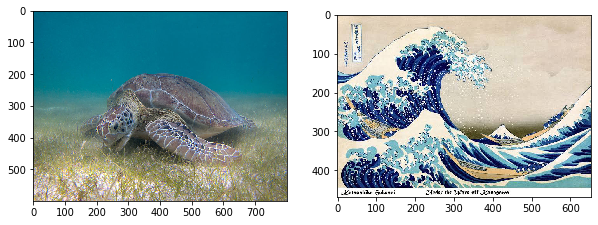

In [258]:
# Enter the path of the respective Images
contentImagePath = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/images/content2.jpg'
styleImagePath   = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/images/style2.jpg'


content = plt.imread(contentImagePath)
style   = plt.imread(styleImagePath)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content)

plt.subplot(1, 2, 2)
plt.imshow(style)

## **Training**

In [0]:
ITERATIONS = 1000

bestImage, bestLoss = runStyleTransfer(contentImagePath,
                                       styleImagePath,
                                       iterations=ITERATIONS)

#### Visualizing the Best Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


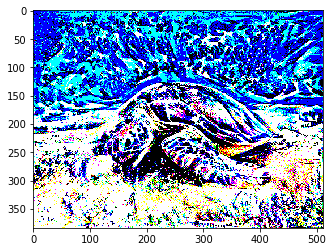

In [262]:
_, height, width, channels = bestImage.shape
new=cv2.cvtColor(bestImage.reshape(height, width, 3), cv2.COLOR_BGR2RGB)
plt.imshow(new)

#### Plotting the Cost Functions

In [0]:
PATH = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/output'
os.chdir(PATH)
contentLog = np.load('contentLoss.npy')
styleLog = np.load('styleLoss.npy')
totalLog = np.load('totalCostLoss.npy')
iterations = list(range(1, 1001))

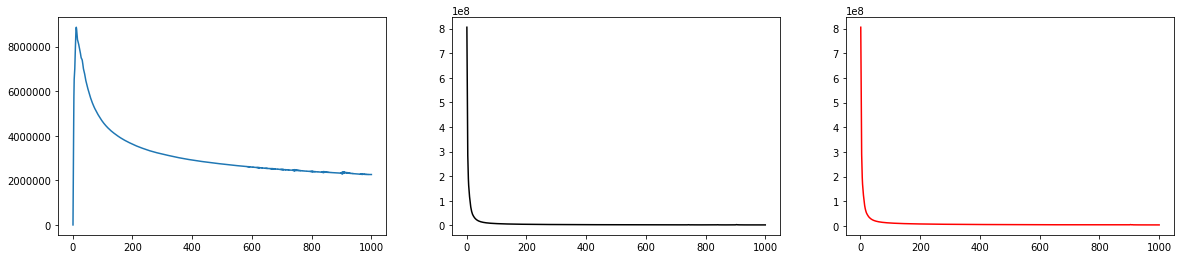

In [264]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.plot(iterations, contentLog)

plt.subplot(1, 3, 2)
plt.plot(iterations, styleLog, 'k')

plt.subplot(1, 3, 3)
plt.plot(iterations, totalLog, 'r')